In [1]:
import os,pickle,torch
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore", category=ConvergenceWarning)
data_num = 50
emotions = ["joy", "surprise", "anger", "fear", "disgust", "sadness"]
task_name = 'Emotion_control'
model_names = ['LLaMA-2-7B-Chat','LLaMA-3-7B-Instruct','Alpaca-7B',
               'DialoGPT-large',
               'GPT-2-large',
               'WizardLM-2-7B',
               #'WizardLM-7B','WizardCoder-7B',
               'WizardMath-7B',
              'ChatGLM-6B',
               #'Guanaco-2-7B'
              ]

In [2]:
general_hidden_collections_all = []
attribute_hidden_list_all = []
for i in range(len(model_names)):
    with open("최종results_{}/평균general.pkl".format(model_names[i]),"rb") as f:
        general_hidden = pickle.load(f)
    with open("최종results_{}/평균hidden_Emotion_control.pkl".format(model_names[i]),"rb") as f:
        attribute_hidden = pickle.load(f)
    general_hidden_collections_all.append(general_hidden)
    attribute_hidden_list_all.append(attribute_hidden)

In [3]:
def plot_per_layer_cosine(emotions,task_name, model_num):

    model_name = model_names[model_num]
    general_hidden_collections = general_hidden_collections_all[model_num]
    attribute_hidden_list= attribute_hidden_list_all[model_num]

    plt.figure(figsize=(6,3 ))
    if model_name in ['LLaMA-2-7B-Chat','LLaMA-3-7B-Instruct','Alpaca-7B','WizardLM-2-7B','WizardLM-7B',
                     'WizardCoder-7B','WizardMath-7B','Guanaco-2-7B']:
        num_of_layer = 33
    if model_name in ['DialoGPT-large', 'GPT-2-large']:
        num_of_layer = 37
    if model_name == 'ChatGLM-6B':
        num_of_layer = 29
    results_for_att_avg = torch.zeros_like(torch.empty(num_of_layer))
    for i, attribute_hidden in enumerate(attribute_hidden_list):
        total_cos_per_layers = []
        for k in range(data_num):
            att_hidden = attribute_hidden[k]
            general_hidden = general_hidden_collections[k]
            #토크들평균낼지 
            cos_per_layers = torch.mean(torch.nn.functional.cosine_similarity(att_hidden, general_hidden, dim=-1), axis=-1).squeeze()
            #cos_per_layers = torch.nn.functional.cosine_similarity(att_hidden, general_hidden, dim=-1).squeeze()
            
            # 마지막 토큰 만 할지
            #cos_per_layers = torch.nn.functional.cosine_similarity(att_hidden[:,:,-1,:], general_hidden[:,:,-1,:], dim=-1).squeeze()
            total_cos_per_layers.append(cos_per_layers)
        result = sum(total_cos_per_layers) / data_num
        plt.plot(result, label=emotions[i])
        results_for_att_avg += result
    plt.xlabel('layers')
    plt.ylabel('Cosine_sim')
    #plt.ylim((0.7,1))
    #plt.legend(loc ='upper right' )
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(model_name)
    #plt.savefig('최종results_llama2-chat/평균{}.png'.format(task_name))
    plt.tight_layout()
    plt.show()
def find_all_sign_changes(gradients):
    sign_changes = []
    for i in range(1, len(gradients)):
        if gradients[i] * gradients[i-1] <0:
            if i >14:
                sign_changes.append((i))
    return sign_changes
    
def compute_gradients(data):
    gradients = []
    for i in range(1, len(data)):
        gradient = data[i] - data[i-1]
        gradients.append(gradient)
    return gradients    

def Logistic_per_layer(layer,att_h_list): 
    hiddens = []
    labels = []
    for i in range(len(att_h_list)):
        for j in range(len(att_h_list[0])):
            hiddens.append(np.array(att_h_list[i][j][layer]))
            labels.append(i)
    
    #x_tr, x_test, y_tr,y_test = train_test_split(hiddens,labels,random_state =1, stratify =labels )
    x_tr, y_tr= hiddens,labels
    model = LogisticRegression(multi_class='ovr',
                              max_iter =40
                              ).fit(x_tr,y_tr)
    return model.score(x_tr,y_tr)



# Figue 4.2, 4.3 , 4.4

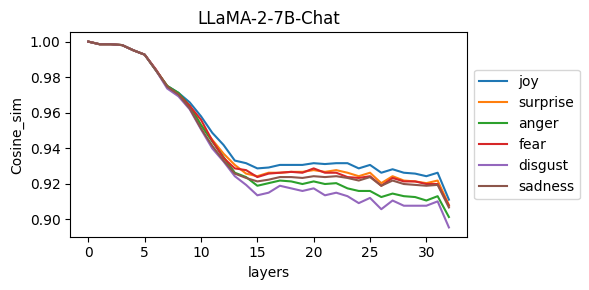

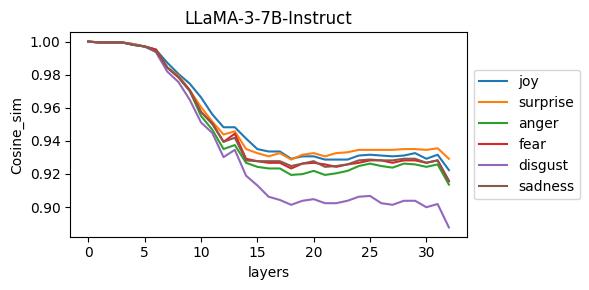

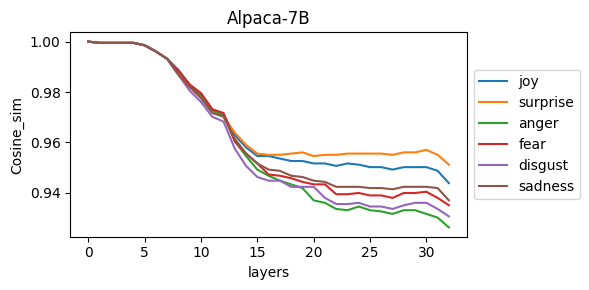

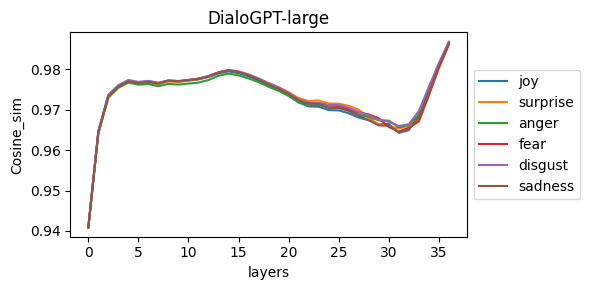

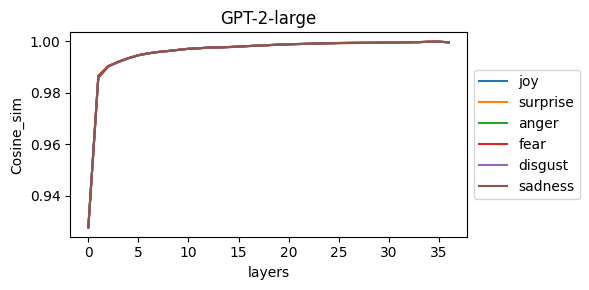

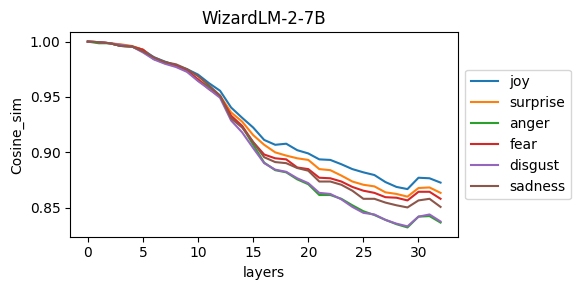

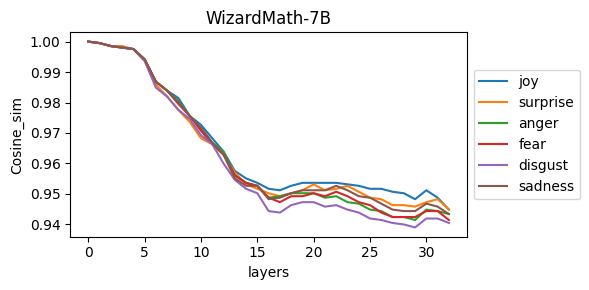

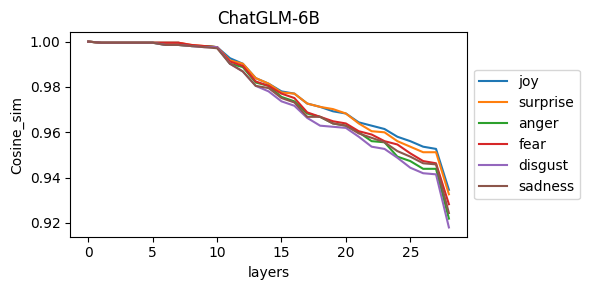

In [4]:
for i in range(len((model_names))):
    plot_per_layer_cosine(emotions,task_name,model_num=i)

# Figue 4.5

In [5]:
def find_all_sign_changes(gradients):
    sign_changes = []
    for i in range(1, len(gradients)):
        if gradients[i] * gradients[i-1] <0:
            if i >14:
                sign_changes.append((i))
    return sign_changes

All sign changes: LLaMA-2-7B-Chat [15]
All sign changes: LLaMA-3-7B-Instruct [18]
All sign changes: Alpaca-7B [22]
All sign changes: DialoGPT-large [31]
All sign changes: GPT-2-large [35]
All sign changes: WizardLM-2-7B [29]
All sign changes: WizardMath-7B [17]
All sign changes: ChatGLM-6B [27]


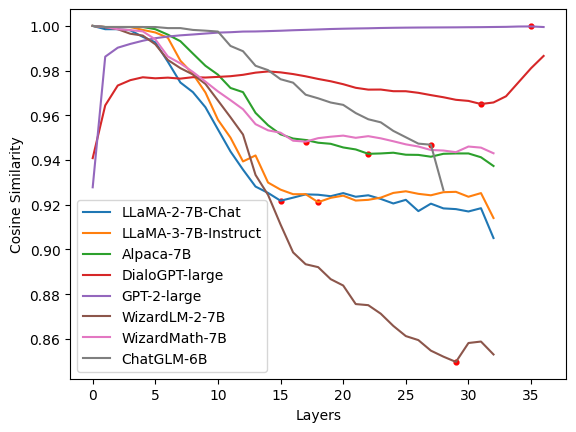

In [6]:
convergence_points = []
for i in range(len((model_names))):
    with open("최종results_{}/평균results_plot_{}.pkl".format(model_names[i],task_name),"rb") as f:
        average_cosine = pickle.load(f)
    
    plt.plot(average_cosine,label = model_names[i])
    gradients = compute_gradients(average_cosine)
    if len(find_all_sign_changes(gradients))<1:
        convergence_point = [27]
    elif i ==3:
        convergence_point = [31]
    
    else: 
        convergence_point = [find_all_sign_changes(gradients)[0]]
    
    plt.scatter(convergence_point,[average_cosine[convergence_point]],s=12,color = 'r')
    convergence_points.append(convergence_point)
    print("All sign changes:",model_names[i], convergence_point)
plt.ylabel('Cosine Similarity')
plt.xlabel('Layers')
plt.legend()
#plt.savefig("/home/wooseok/layer_analysis_prompt_based/paper_figures/Cosine_similarity and convergence point of 3 models.png")
plt.show()


In [7]:
convergence_points= [item for sublist in convergence_points for item in sublist]
convergence_points

[15, 18, 22, 31, 35, 29, 17, 27]

# Figue 4.9, 4.10 , 4.11, 4.12

In [60]:
all_test = []
convergence_points_LR = []
for i in range(len((model_names))):
    general_hidden_collections = general_hidden_collections_all[i]
    attribute_hidden_list= attribute_hidden_list_all[i]

    gene_h = []
    for k in range(len(general_hidden_collections)):
        gene_h.append(torch.mean(general_hidden_collections[k].squeeze(),1))
    att_h_list = []
    for jj in range(len(attribute_hidden_list)):
        att_h = []
        for ii in range(len(attribute_hidden_list[jj])):
            att_h.append(torch.mean(attribute_hidden_list[jj][ii].squeeze(),1))
        att_h_list.append(att_h)
    
    test_acc = []
    for j in tqdm(range(gene_h[0].size(0))):
        test_acc.append(Logistic_per_layer(j,att_h_list))
    
    plt.figure(figsize=(5,3 ))
    plt.plot(test_acc)
    all_test.append(test_acc)
    max_test_acc = max(test_acc)
    max_test_acc_index = test_acc.index(max_test_acc)
    if i==3:    
        plt.scatter(14, max_test_acc, s=15, color='r')  # Red dot on the max point
    else:
        plt.scatter(max_test_acc_index, max_test_acc, s=15, color='r')  # Red dot on the max point
    plt.title(model_names[i])
    print("convergence_point:",np.argmax(test_acc))
    if i==3:    
        convergence_points_LR.append(14)
    else:
        convergence_points_LR.append(np.argmax(test_acc))
    plt.ylabel('Logistic Regression Accuracy')
    plt.xlabel('Layers')
    
    plt.tight_layout()
    plt.show()

NameError: name 'general_hidden_collections_all' is not defined

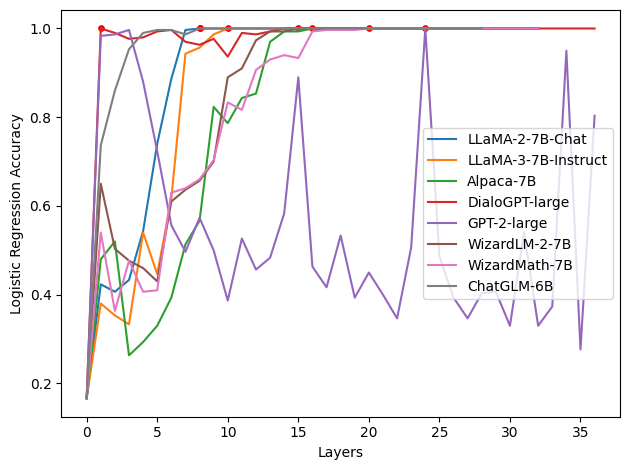

In [41]:
for i in range(len((model_names))):    
    
    test_acc = all_test[i]
    plt.plot(test_acc,label = model_names[i])
    all_test.append(test_acc)
    max_test_acc = max(test_acc)
    max_test_acc_index = test_acc.index(max_test_acc)
    plt.scatter(max_test_acc_index, max_test_acc, s=15, color='r')  # Red dot on the max point

plt.ylabel('Logistic Regression Accuracy')
plt.xlabel('Layers')
plt.legend()
    
plt.tight_layout()
plt.show()

In [27]:
import os,pickle,torch
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore", category=ConvergenceWarning)
data_num = 50
emotions = ["joy", "surprise", "anger", "fear", "disgust", "sadness"]
task_name = 'Emotion_control'
model_names = ['LLaMA-2-7B-Chat','LLaMA-3-7B-Instruct','Alpaca-7B',
               'DialoGPT-large',
               'GPT-2-large',
               'WizardLM-2-7B',
               #'WizardLM-7B','WizardCoder-7B',
               'WizardMath-7B',
              'ChatGLM-6B',
               #'Guanaco-2-7B'
              ]


# general_hidden_collections_all_last = []
# attribute_hidden_list_all_last = []
# for i in range(len(model_names)):
#     with open("최종results_{}/general.pkl".format(model_names[i]),"rb") as f:
#         general_hidden = pickle.load(f)
#     with open("최종results_{}/hidden_Emotion_control.pkl".format(model_names[i]),"rb") as f:
#         attribute_hidden = pickle.load(f)
#     general_hidden_collections_all_last.append(general_hidden)
#     attribute_hidden_list_all_last.append(attribute_hidden)

In [46]:
import matplotlib.font_manager as font_manager
title_font = font_manager.FontProperties(size=18)
font = font_manager.FontProperties(size=16)

In [51]:

def plot_per_layer_per_attribute(emotions, attribute_hidden_list,general_hidden_collections,task_name):
    plt.figure(figsize=(5,3 ))
    general_hidden_collections = torch.stack(general_hidden_collections, dim=0).permute(1, 0, 2) # layer, batch, feature_dim


    results_for_att_avg = torch.zeros_like(torch.empty(33))
    for i, attribute_hidden in enumerate(attribute_hidden_list):
        total_cos_per_layers = []

        attribute_hidden = torch.stack(attribute_hidden, dim=0).permute(1, 0, 2) # layer, batch, feature_dim
        hidden = torch.cat([attribute_hidden, general_hidden_collections], dim=1)
        N1 = attribute_hidden.size(1)
        N2 = general_hidden_collections.size(1)

        plt.figure(figsize=(8, 32))

        for l in range(attribute_hidden.size(0)):
            pca = PCA(n_components=2)
            hidden_pca = pca.fit_transform(hidden[l])

            plt.subplot(11, 3, l + 1)
            plt.scatter(hidden_pca[:N1, 0], hidden_pca[:N1, 1], label=emotions[i], c="blue")
            plt.scatter(hidden_pca[N1:, 0], hidden_pca[N1:, 1], label="general", c="orange")
            plt.title(f"Layer {l}")
            plt.legend()

        plt.tight_layout()
        #plt.savefig(f"최종results_alpaca/last_token_hidden_state_pca_emotion_{emotions[i]}.png")
    
def plot_per_layer_all_attribute(emotions, attribute_hidden_list,general_hidden_collections,task_name):
    plt.figure(figsize=(5,3 ))

    general_hidden_collections = torch.stack(general_hidden_collections, dim=0).permute(1, 0, 2) # layer, batch, feature_dim
    labels = [0] * general_hidden_collections.size(1)
    hidden = [general_hidden_collections]

    # 코사인 유사도를 구하고 평균내기
    #plt.subplot(1, 2, 1)
    for i, attribute_hidden in enumerate(attribute_hidden_list):
        attribute_hidden = torch.stack(attribute_hidden, dim=0).permute(1, 0, 2) # layer, batch, feature_dim
        labels += [i + 1] * attribute_hidden.size(1)

        hidden.append(attribute_hidden)

    hidden = torch.cat(hidden, dim=1)
    labels = np.array(labels)
    emotions = ["general"] + emotions

    plt.figure(figsize=(8, 32))

    for l in range(attribute_hidden.size(0)):
        pca = PCA(n_components=2)
        hidden_pca = pca.fit_transform(hidden[l])

        plt.subplot(11, 3, l + 1)
        for j in range(len(attribute_hidden_list) + 1):
            plt.scatter(hidden_pca[labels == j, 0], hidden_pca[labels == j, 1], label=emotions[j], s=3)
        plt.title(f"Layer {l}")
        if l % 6 == 0:
            plt.legend()

    plt.tight_layout()
    #plt.savefig(f"최종results_alpaca/last_token_hidden_state_pca.png")


def plot_per_layer_all_attribute_contraction(model_name, attribute_hidden_list, general_hidden_collections, task_name, emotions, legend=False):
    numbers_of_layers = attribute_hidden_list[0][0].shape[0]
    general_hidden_collections = torch.stack(general_hidden_collections, dim=0).permute(1, 0, 2)  # layer, batch, feature_dim
    labels = [0] * general_hidden_collections.size(1)
    hidden = [general_hidden_collections]

    for i, attribute_hidden in enumerate(attribute_hidden_list):
        attribute_hidden = torch.stack(attribute_hidden, dim=0).permute(1, 0, 2)  # layer, batch, feature_dim
        labels += [i + 1] * attribute_hidden.size(1)

        hidden.append(attribute_hidden)

    hidden = torch.cat(hidden, dim=1)
    labels = np.array(labels)
    emotions = ["general"] + emotions

    plt.figure(figsize=(16, 8))
    count = 0
        
    for i, l in enumerate(np.linspace(2, numbers_of_layers - 1, 8)):  # l values: 2, 5, 8, ..., 29
        l = int(l)
        pca = PCA(n_components=2)
        hidden_pca = pca.fit_transform(hidden[l])

        plt.subplot(2, 4, count + 1)
        for j in range(len(attribute_hidden_list) + 1):
            plt.scatter(hidden_pca[labels == j, 0], hidden_pca[labels == j, 1], label=emotions[j], s=5)
        plt.title(f"Layer {l}", fontdict = {'fontsize' : 18})
        plt.xlabel("PC1", fontsize=16)
        plt.ylabel("PC2", fontsize=16)
        if legend is True and i == 3:
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop=font)
        count += 1

    plt.tight_layout()
    plt.savefig(f"./paper_figures/pca_{model_name}.png")
    plt.show()
    plt.close()
    #plt.savefig(f"최종results_alpaca/zzlast_token_hidden_state_pca.png")



# Figue 4.6, 4.7 , 4.8

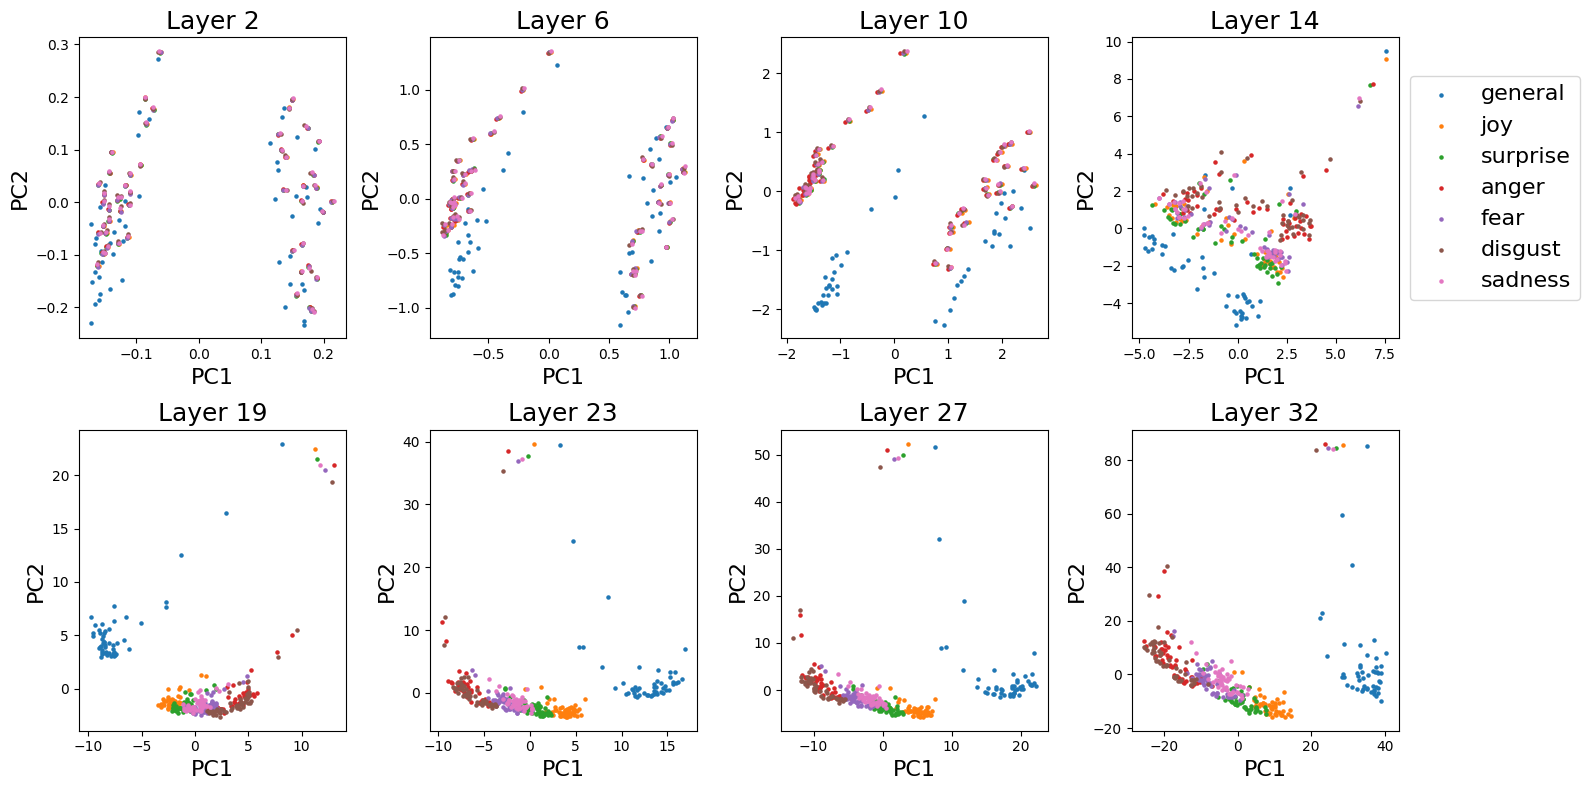

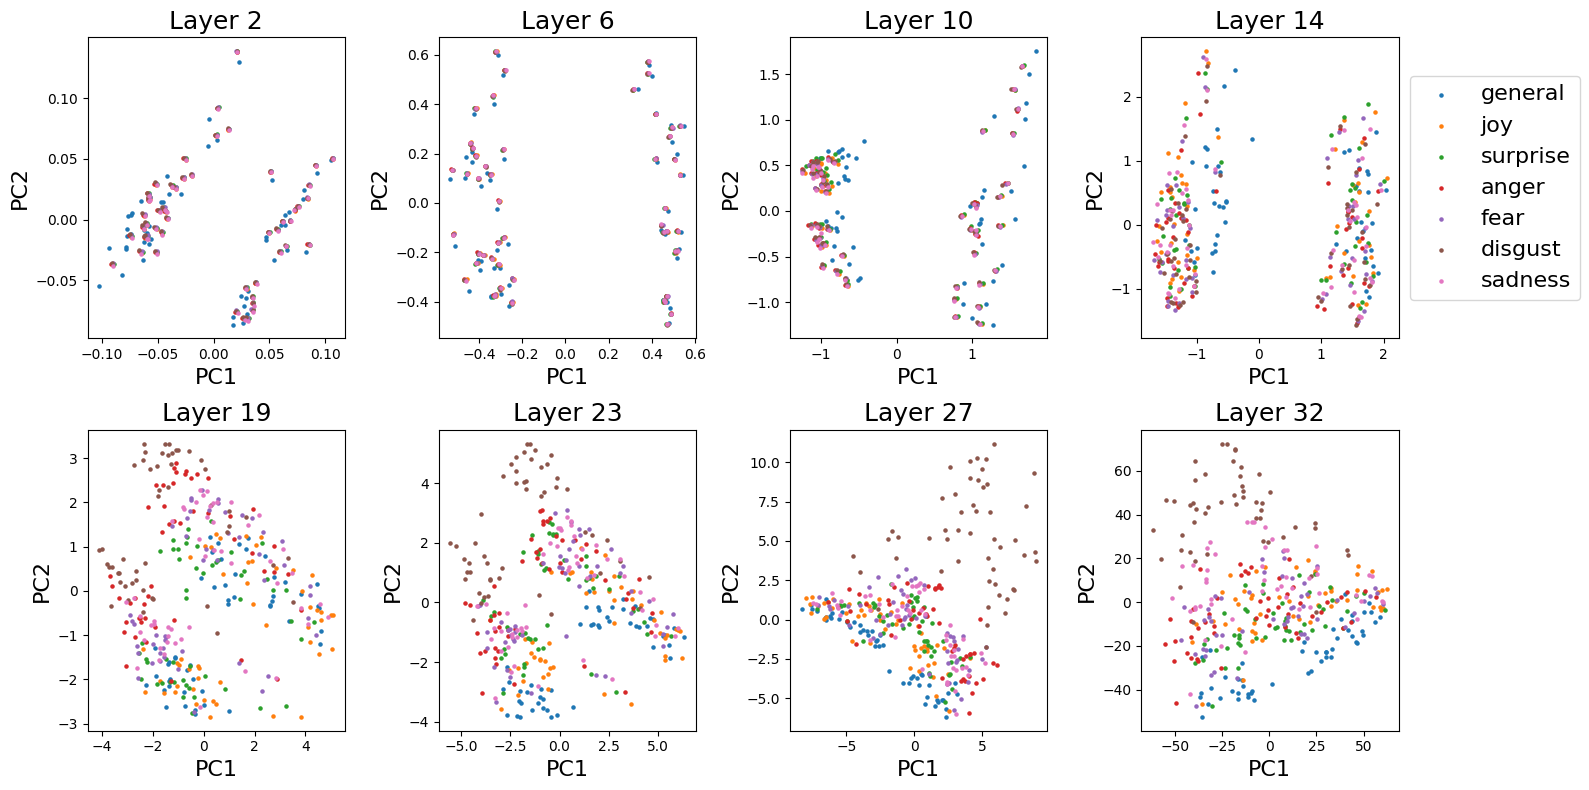

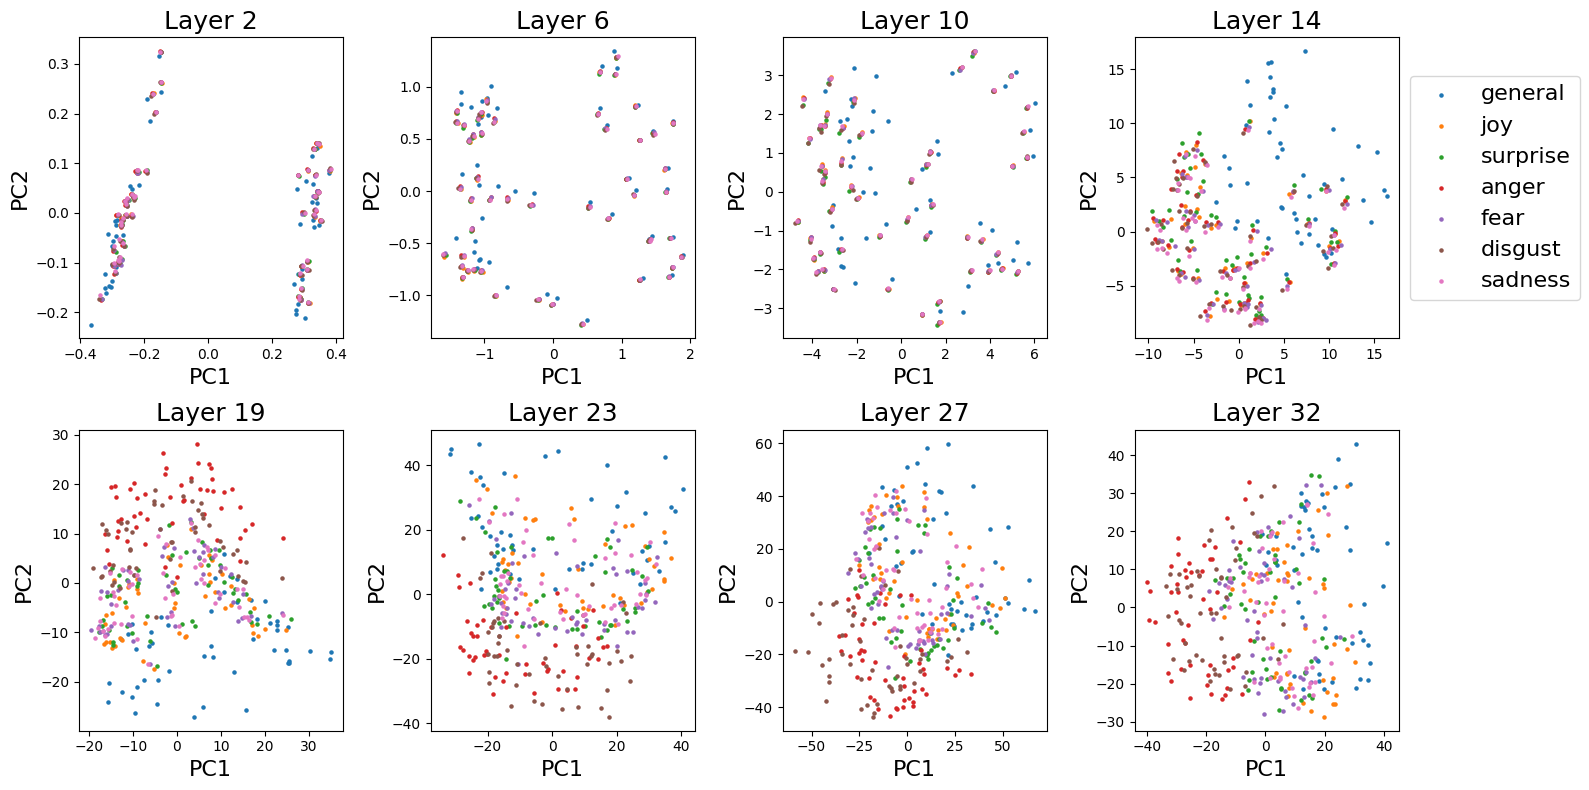

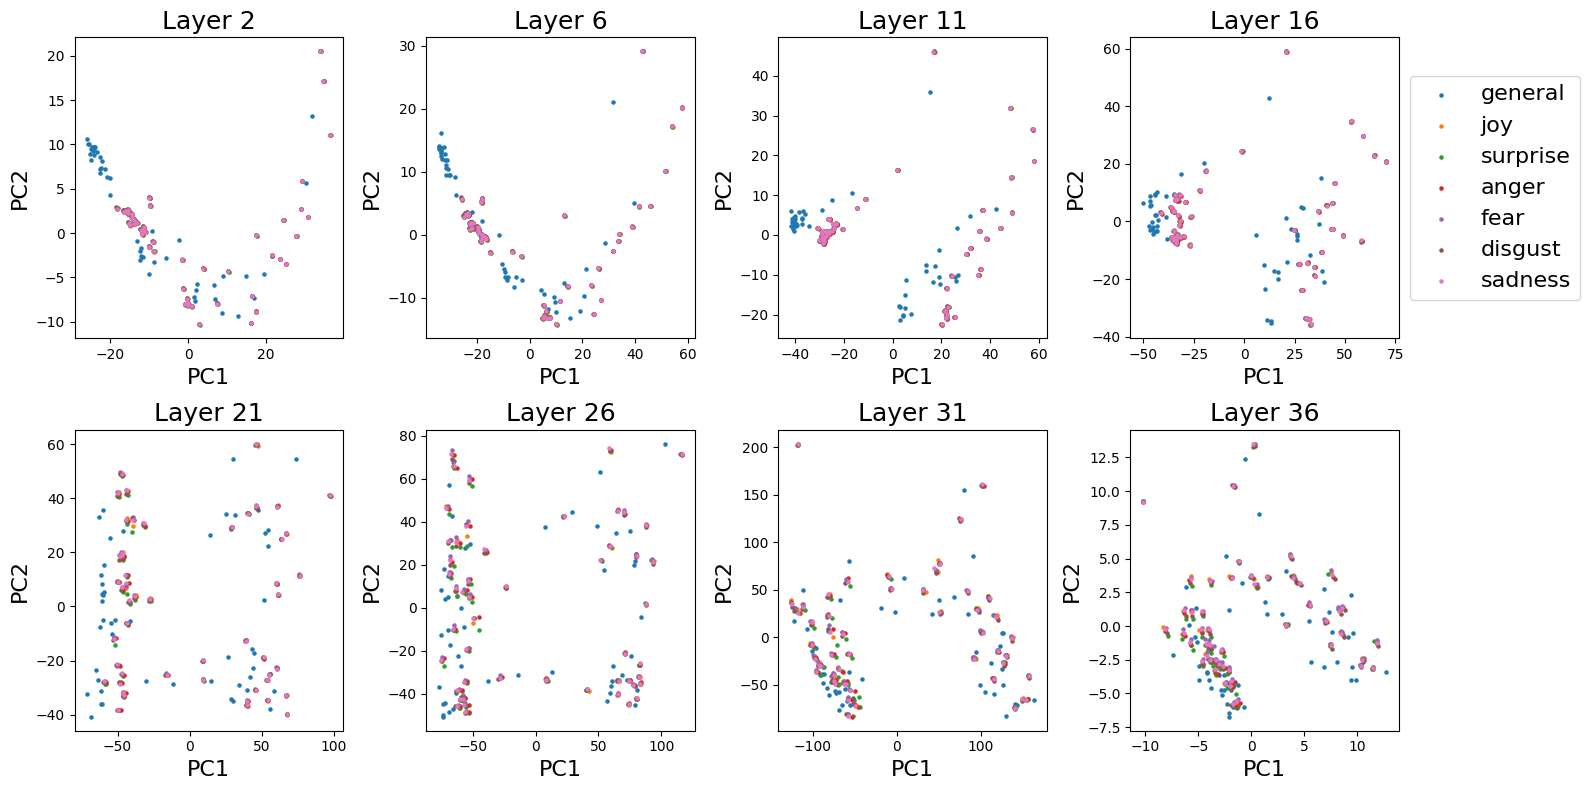

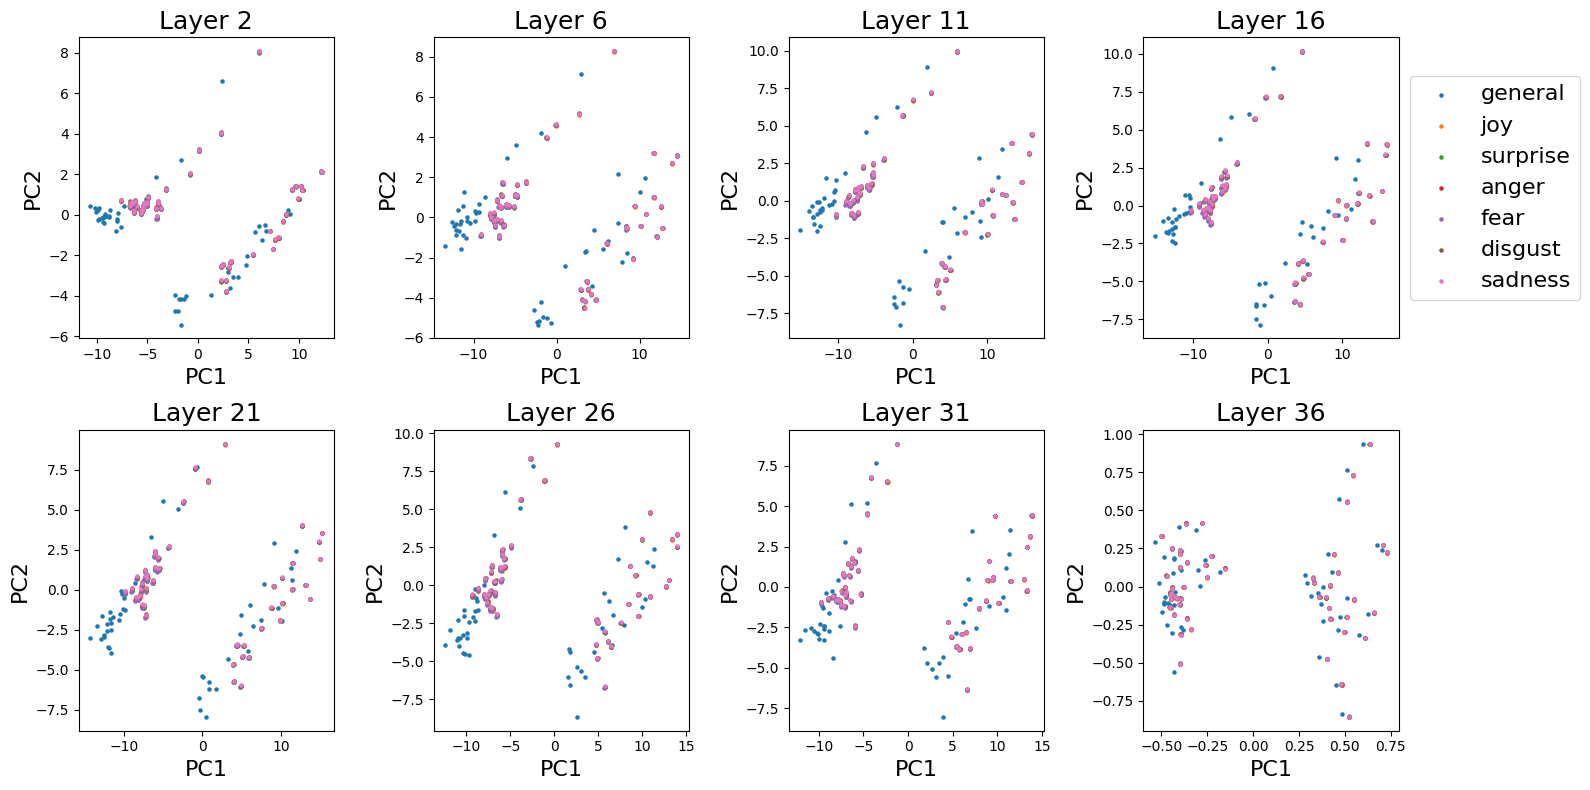

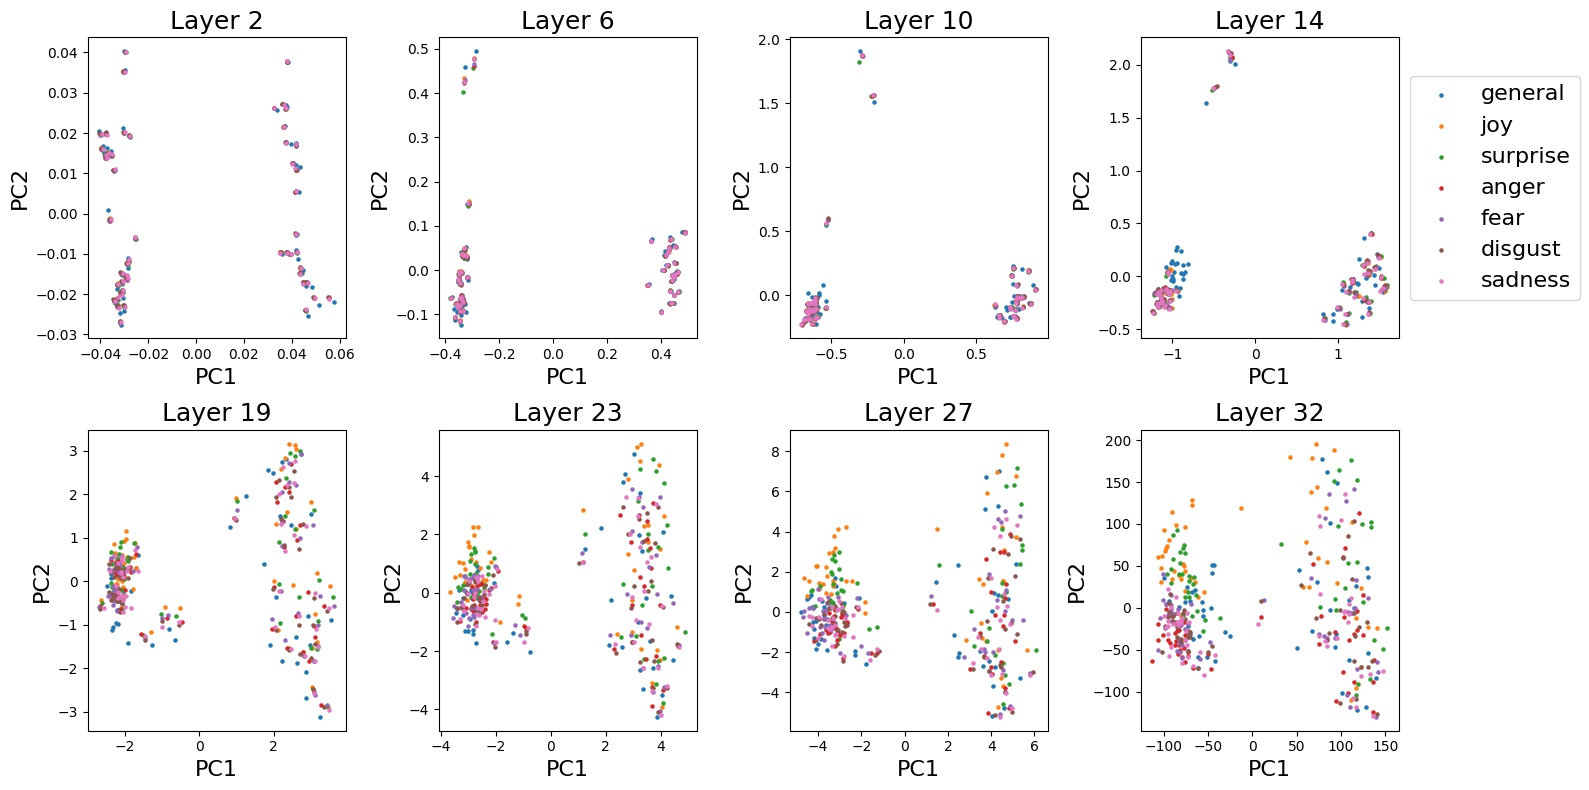

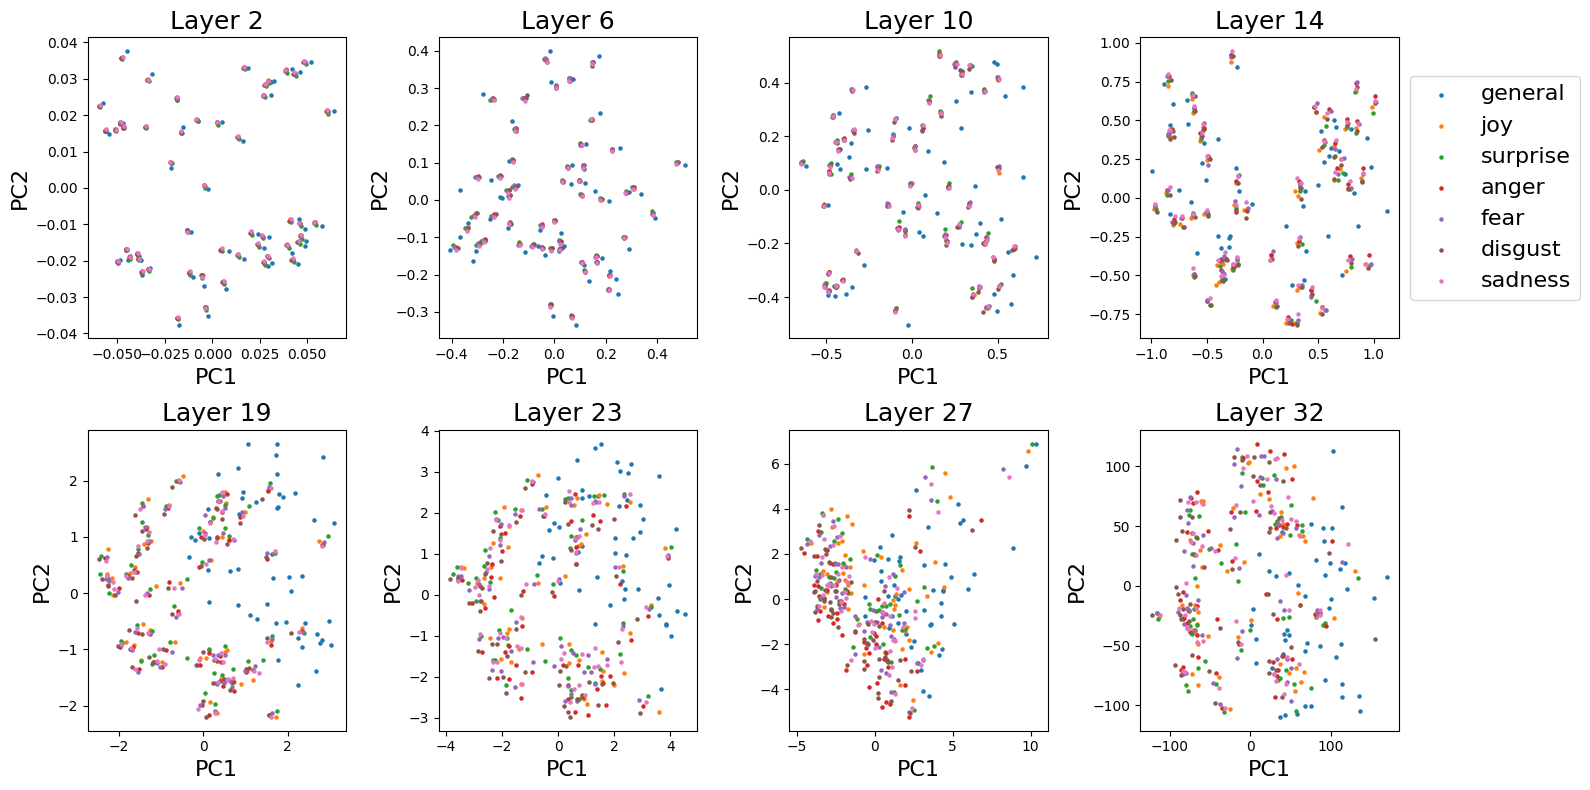

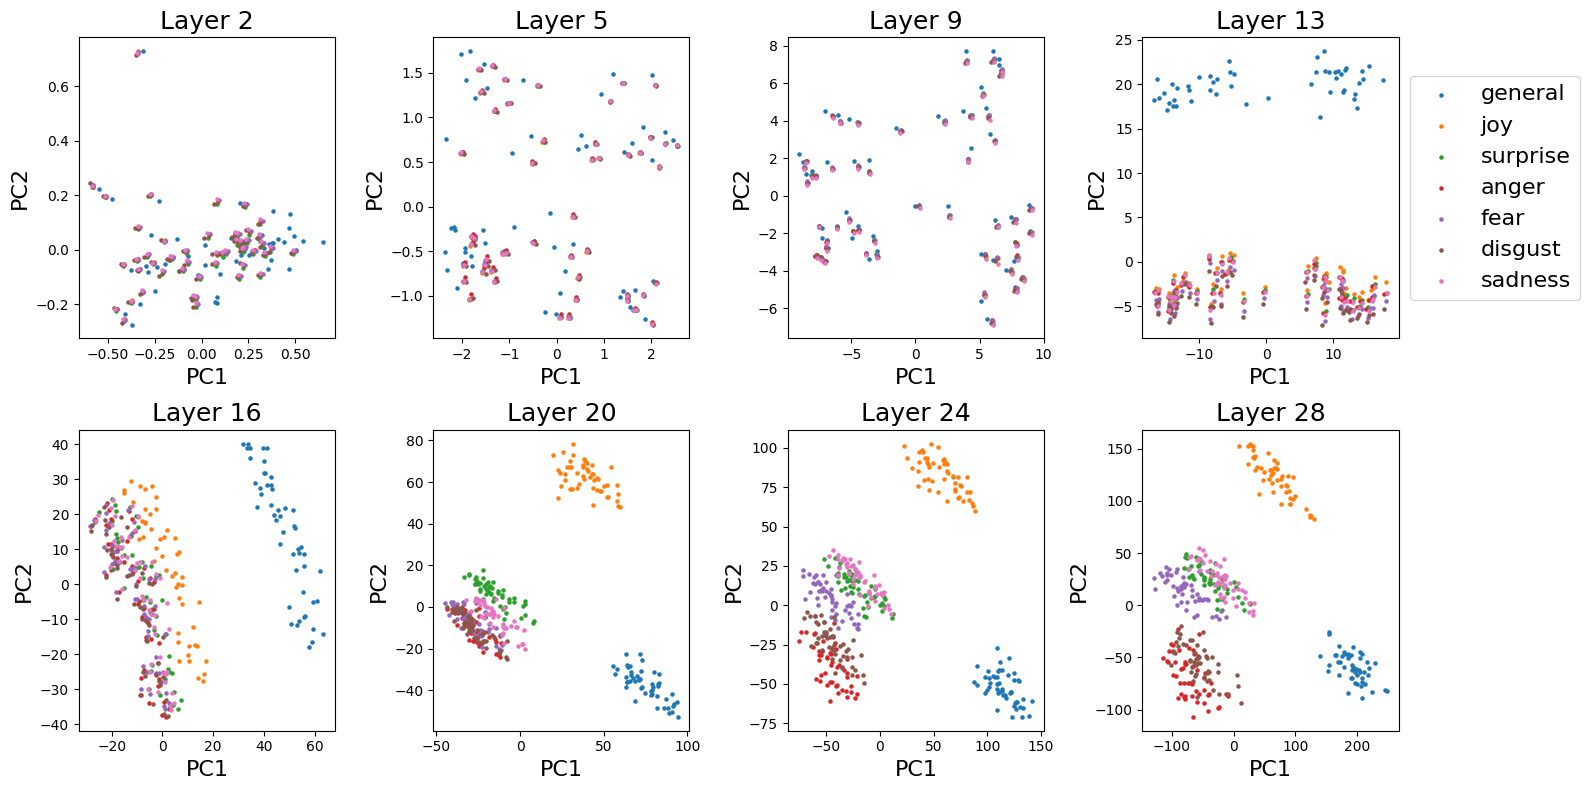

In [52]:
def run_pca(model_name):
    i = model_names.index(model_name)
    with open("최종results_{}/general.pkl".format(model_names[i]),"rb") as f:
        general_hidden = pickle.load(f)
    with open("최종results_{}/hidden_Emotion_control.pkl".format(model_names[i]),"rb") as f:
        attribute_hidden = pickle.load(f)

    plot_per_layer_all_attribute_contraction(model_name, attribute_hidden, general_hidden, task_name, emotions, legend=True)

# Call the function
for i in range(len(model_names)):
    run_pca(model_names[i])


# Figure 3.6

In [30]:
binary_acc_general_all = []

for i in range(len(model_names)):
    with open("최종results_{}/accuracy_binary_general.pkl".format(model_names[i]),"rb") as f:
        binary_acc_general = pickle.load(f)
    binary_acc_general_all.append(binary_acc_general)

binary_acc_controlled_all = []
for i in range(len(model_names)):
    with open("최종results_{}/accuracy_binary_controlled.pkl".format(model_names[i]),"rb") as f:
        binary_acc_controlled = pickle.load(f)
    binary_acc_controlled_all.append(binary_acc_controlled)
    
multi_acc_controlled_all = []
for i in range(len(model_names)):
    with open("최종results_{}/accuracy_multi_controlled.pkl".format(model_names[i]),"rb") as f:
        multi_acc_controlled = pickle.load(f)
    multi_acc_controlled_all.append(multi_acc_controlled)

In [11]:
binary_acc_controlled_all

[[88.0, 92.0, 90.0, 90.0, 57.99999999999999, 82.0],
 [86.0, 90.0, 68.0, 74.0, 86.0, 50.0],
 [82.0, 57.99999999999999, 14.000000000000002, 60.0, 22.0, 22.0],
 [72.0, 44.0, 14.000000000000002, 14.000000000000002, 8.0, 0.0],
 [40.0, 50.0, 34.0, 14.000000000000002, 6.0, 10.0],
 [98.0, 80.0, 12.0, 36.0, 10.0, 2.0],
 [86.0, 72.0, 28.000000000000004, 46.0, 32.0, 32.0],
 [86.0, 82.0, 34.0, 64.0, 18.0, 32.0]]

In [31]:
model_names = ['LLaMA-2-7B-Chat','LLaMA-3-7B-Instruct','Alpaca-7B',
               'DialoGPT-large',
               'GPT-2-large',
               'WizardLM-2-7B',
               #'WizardLM-7B','WizardCoder-7B',
               'WizardMath-7B',
              'ChatGLM-6B',
               #'Guanaco-2-7B'
              ]

In [13]:
len(alphas)

16

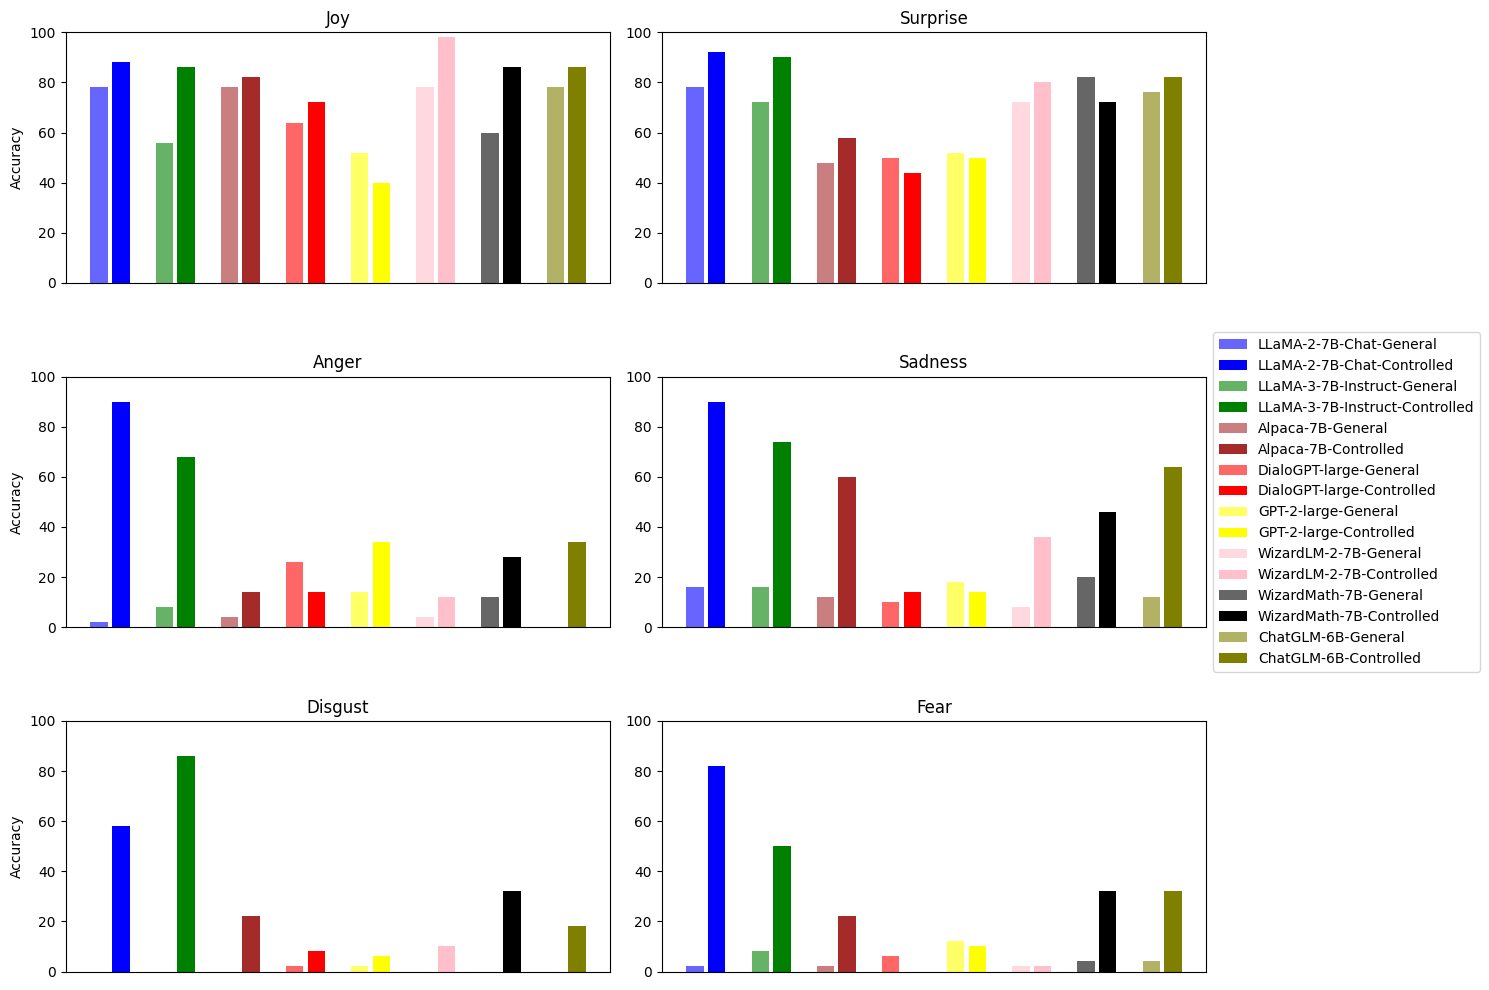

In [59]:
import random
import matplotlib.colors as mcolors

att_names = ["Joy", "Surprise", "Anger", "Sadness", "Disgust", "Fear"]

fig, axs = plt.subplots(3, 2, figsize=(15, 10))

colors = ['b', 'b', 'g', 'g','brown','brown','red','red','yellow','yellow',
          'pink','pink','black','black'
          ,'olive', 'olive'# 'g', 'g','brown','brown','red','red'
         ]
alphas = [0.6, 1]*len(model_names)

for i in range(len(att_names)):
    ax = axs[i // 2, i % 2]
    bars = []
    bars.append(ax.bar(1, binary_acc_general_all[0][i], width=0.8, color=colors[0], alpha=alphas[0]))
    bars.append(ax.bar(2, binary_acc_controlled_all[0][i], width=0.8, color=colors[1], alpha=alphas[1]))
    bars.append(ax.bar(4, binary_acc_general_all[1][i], width=0.8, color=colors[2], alpha=alphas[2]))
    bars.append(ax.bar(5, binary_acc_controlled_all[1][i], width=0.8, color=colors[3], alpha=alphas[3]))
    bars.append(ax.bar(7, binary_acc_general_all[2][i], width=0.8, color=colors[4], alpha=alphas[4]))
    bars.append(ax.bar(8, binary_acc_controlled_all[2][i], width=0.8, color=colors[5], alpha=alphas[5]))
    
    bars.append(ax.bar(10, binary_acc_general_all[3][i], width=0.8, color=colors[6], alpha=alphas[6]))
    bars.append(ax.bar(11, binary_acc_controlled_all[3][i], width=0.8, color=colors[7], alpha=alphas[7]))
    bars.append(ax.bar(13, binary_acc_general_all[4][i], width=0.8, color=colors[8], alpha=alphas[8]))
    bars.append(ax.bar(14, binary_acc_controlled_all[4][i], width=0.8, color=colors[9], alpha=alphas[9]))
    bars.append(ax.bar(16, binary_acc_general_all[5][i], width=0.8, color=colors[10], alpha=alphas[10]))
    bars.append(ax.bar(17, binary_acc_controlled_all[5][i], width=0.8, color=colors[11], alpha=alphas[11]))
    bars.append(ax.bar(19, binary_acc_general_all[6][i], width=0.8, color=colors[12], alpha=alphas[12]))
    bars.append(ax.bar(20, binary_acc_controlled_all[6][i], width=0.8, color=colors[13], alpha=alphas[13]))
    
    bars.append(ax.bar(22, binary_acc_general_all[7][i], width=0.8, color=colors[14], alpha=alphas[14]))
    bars.append(ax.bar(23, binary_acc_controlled_all[7][i], width=0.8, color=colors[15], alpha=alphas[15]))
    '''
    bars.append(ax.bar("i", binary_acc_general_all[8][i], width=0.4, color=colors[16], alpha=alphas[16]))
    bars.append(ax.bar("j", binary_acc_controlled_all[8][i], width=0.4, color=colors[17], alpha=alphas[17]))
    bars.append(ax.bar("k", binary_acc_general_all[9][i], width=0.4, color=colors[18], alpha=alphas[18]))
    bars.append(ax.bar("l", binary_acc_controlled_all[9][i], width=0.4, color=colors[19], alpha=alphas[19]))
    bars.append(ax.bar("m", binary_acc_general_all[10][i], width=0.4, color=colors[20], alpha=alphas[20]))
    bars.append(ax.bar("n", binary_acc_controlled_all[10][i], width=0.4, color=colors[21], alpha=alphas[21]))
    '''
    ax.set_xticks([])
    ax.set_title(att_names[i])
    if i % 2 == 0:
        ax.set_ylabel('Accuracy')
    if i == 3:
        ax.legend(bars, [model_names[0]+'-General', model_names[0]+'-Controlled',
                         model_names[1]+'-General', model_names[1]+'-Controlled',
                         model_names[2]+'-General', model_names[2]+'-Controlled',
                         model_names[3]+'-General', model_names[3]+'-Controlled',
                         model_names[4]+'-General', model_names[4]+'-Controlled',
                        model_names[5]+'-General', model_names[5]+'-Controlled',
                         model_names[6]+'-General', model_names[6]+'-Controlled',
                         
                         model_names[7]+'-General', model_names[7]+'-Controlled',
                         #model_names[8]+'-General', model_names[8]+'-Controlled',
                        #model_names[9]+'-General', model_names[9]+'-Controlled',
                         #model_names[10]+'-General', model_names[10]+'-Controlled'
                         
                        ],
                  loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig("paper_figures/generated_sentence_accracy.png")
plt.show()
plt.close()

# Table 3.2

In [53]:
convergence_points = [15, 18, 22,31, 35, 29, 17, 27]
convergence_points_LR =[8,10,16,14,24,15,20,8]

In [54]:
import pandas as pd
data = {
    'Model':model_names,
    'Without control': np.round(np.mean(binary_acc_general_all,1),2),
    'Binary':np.round(np.mean(binary_acc_controlled_all,1),2),
    'Multi': np.round(np.mean(multi_acc_controlled_all,1),2),
    'convergence_points':convergence_points,
    'convergence_points_LR': convergence_points_LR
}

df = pd.DataFrame(data)
df

,Model,Without control,Binary,Multi,convergence_points,convergence_points_LR
0,LLaMA-2-7B-Chat,29.33,83.33,73.00,15,8
1,LLaMA-3-7B-Instruct,26.67,75.67,55.00,18,10
2,Alpaca-7B,24.00,43.00,37.00,22,16
3,DialoGPT-large,26.33,25.33,18.67,31,14
4,GPT-2-large,25.00,25.67,16.33,35,24
5,WizardLM-2-7B,27.33,39.67,37.33,29,15
6,WizardMath-7B,29.67,49.33,37.00,17,20
7,ChatGLM-6B,28.33,52.67,44.00,27,8


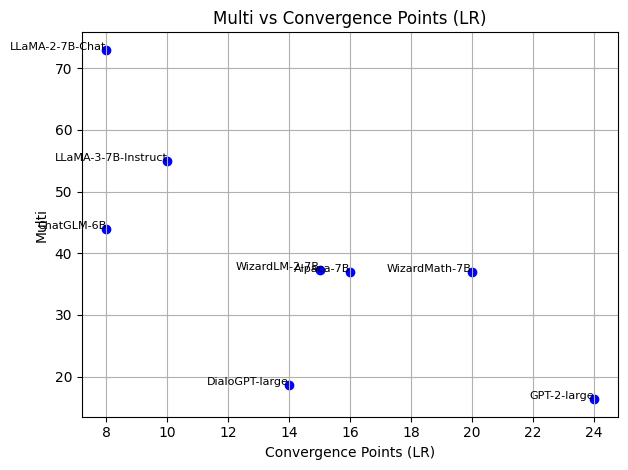

In [57]:
plt.scatter(df['convergence_points_LR'], df['Multi'], color='blue')

# 각 점에 라벨 추가
for i, txt in enumerate(df['Model']):
    plt.annotate(txt, (df['convergence_points_LR'][i], df['Multi'][i]), fontsize=8, ha='right')

# 축 라벨 및 제목 추가
plt.xlabel('Convergence Points (LR)')
plt.ylabel('Multi')
plt.title('Multi vs Convergence Points (LR)')

# 그래프 표시
plt.grid(True)
plt.tight_layout()
plt.savefig("paper_figures/multi_vs_convergence_points_LR.png")
plt.show()

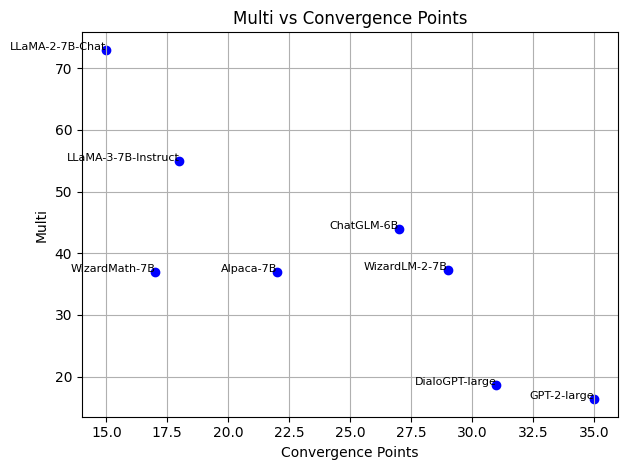

In [58]:

plt.scatter(df['convergence_points'], df['Multi'], color='blue')

# 각 점에 라벨 추가
for i, txt in enumerate(df['Model']):
    plt.annotate(txt, (df['convergence_points'][i], df['Multi'][i]), fontsize=8, ha='right')

# 축 라벨 및 제목 추가
plt.xlabel('Convergence Points')
plt.ylabel('Multi')
plt.title('Multi vs Convergence Points')

# 그래프 표시
plt.grid(True)
plt.tight_layout()
plt.savefig("paper_figures/multi_vs_convergence_points.png")
plt.show()

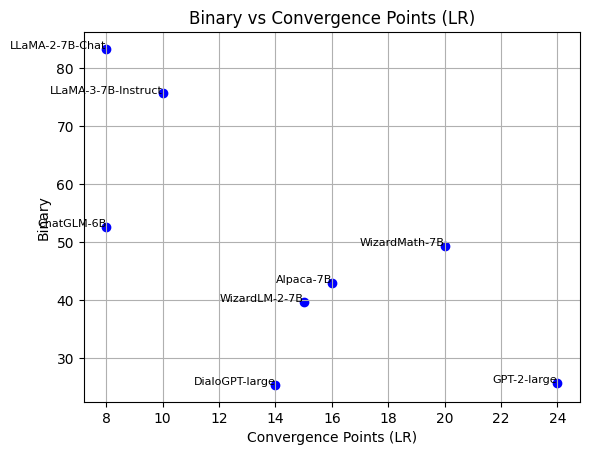

In [23]:
plt.scatter(df['convergence_points_LR'], df['Binary'], color='blue')

# 각 점에 라벨 추가
for i, txt in enumerate(df['Model']):
    plt.annotate(txt, (df['convergence_points_LR'][i], df['Binary'][i]), fontsize=8, ha='right')

# 축 라벨 및 제목 추가
plt.xlabel('Convergence Points (LR)')
plt.ylabel('Binary')
plt.title('Binary vs Convergence Points (LR)')

# 그래프 표시
plt.grid(True)
plt.show()

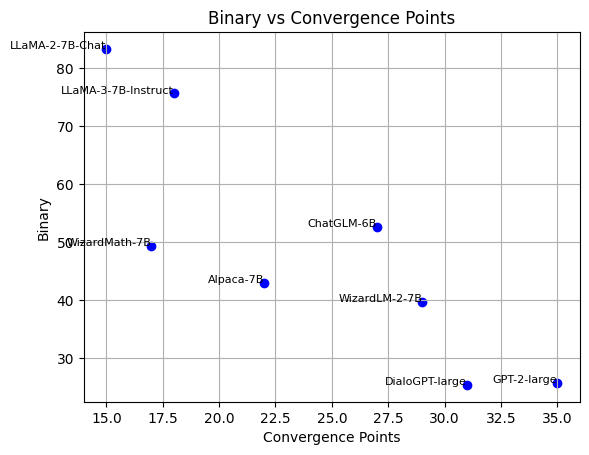

In [24]:
plt.scatter(df['convergence_points'], df['Binary'], color='blue')

# 각 점에 라벨 추가
for i, txt in enumerate(df['Model']):
    plt.annotate(txt, (df['convergence_points'][i], df['Binary'][i]), fontsize=8, ha='right')

# 축 라벨 및 제목 추가
plt.xlabel('Convergence Points')
plt.ylabel('Binary')
plt.title('Binary vs Convergence Points')

# 그래프 표시
plt.grid(True)
plt.show()

In [25]:
# 'Binary' 열 기준으로 내림차순 정렬
df_sorted = df.sort_values(by='Binary', ascending=False)

# 정렬된 데이터프레임 출력
df_sorted

,Model,Without control,Binary,Multi,convergence_points,convergence_points_LR
0,LLaMA-2-7B-Chat,29.33,83.33,73.00,15,8
1,LLaMA-3-7B-Instruct,26.67,75.67,55.00,18,10
7,ChatGLM-6B,28.33,52.67,44.00,27,8
6,WizardMath-7B,29.67,49.33,37.00,17,20
2,Alpaca-7B,24.00,43.00,37.00,22,16
5,WizardLM-2-7B,27.33,39.67,37.33,29,15
4,GPT-2-large,25.00,25.67,16.33,35,24
3,DialoGPT-large,26.33,25.33,18.67,31,14


In [26]:
# 'Binary' 열 기준으로 내림차순 정렬
df_sorted = df.sort_values(by='Multi', ascending=False)

# 정렬된 데이터프레임 출력
df_sorted

,Model,Without control,Binary,Multi,convergence_points,convergence_points_LR
0,LLaMA-2-7B-Chat,29.33,83.33,73.00,15,8
1,LLaMA-3-7B-Instruct,26.67,75.67,55.00,18,10
7,ChatGLM-6B,28.33,52.67,44.00,27,8
5,WizardLM-2-7B,27.33,39.67,37.33,29,15
2,Alpaca-7B,24.00,43.00,37.00,22,16
6,WizardMath-7B,29.67,49.33,37.00,17,20
3,DialoGPT-large,26.33,25.33,18.67,31,14
4,GPT-2-large,25.00,25.67,16.33,35,24
